# Microsoft Movie Analysis Project

## Project Summary

## Data Exploration & Prep


### Import Libraries


In [66]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set display options to remove scientific notation and allow dataframe rows to display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_rows", None)

### Source Data Loads

In [67]:
# Load IMDB Basics as title master, set index and convert minutes from float
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].astype('Int64')

In [68]:
# Load IMDB Ratings, set index, standarized column names and convert votes to integer
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_ratings.rename(columns={'averagerating': "avg_rating", 'numvotes': 'num_votes'}, inplace=True)
imdb_ratings['num_votes'] = imdb_ratings['num_votes'].astype('Int64')

In [69]:
# Load BOM Movie Gross, transform gross columns from mixed data types into integer
bom = pd.read_csv('data/bom.movie_gross.csv')
bom['domestic_gross'].replace('"', '', inplace=True)
bom['domestic_gross'].fillna(0, inplace=True)
bom['domestic_gross'] = bom['domestic_gross'].astype('Int64')
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')
bom['foreign_gross'].fillna(0, inplace=True)
bom['foreign_gross'] = bom['foreign_gross'].astype('float').round(0).astype('Int64')

In [197]:
# Load TN Budget, transform gross columns from mixed data types into integer
tn = pd.read_csv('data/tn.movie_budgets.csv')

# Convert Date and create Year
tn['release_date'] = pd.to_datetime(tn['release_date'], infer_datetime_format=True).dt.floor('d')
tn['year'] = tn['release_date'].dt.year
currency_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[currency_cols] = tn[currency_cols].apply(lambda x: x.str.replace('$', '').str.replace(',', ''))
tn[currency_cols] = tn[currency_cols].astype('float')

# Clean up duplicate row - single movie found in data profiling
home1 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-04-23')] #more complete record
home2 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-06-05')] #contains budget $12m
home2_budget = home2['production_budget'].sum()
home1['production_budget'] = home1['production_budget'] + home2_budget

# Update/drop duplicate
tn.drop(home2.index, inplace = True)
tn.update(home1)

# Transform some columns
tn['worldwide_profit'] = tn['worldwide_gross'] - tn['production_budget']
tn['profit_margin'] = (tn['worldwide_profit'] / tn['production_budget'])*100

#Validation
display(tn[(tn['movie'] == 'Home') ])
tn.head()

<ipython-input-197-f90f646bb33e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home1['production_budget'] = home1['production_budget'] + home2_budget


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin
243,44.00,2015-03-27,Home,"130,000,000.00","177,397,510.00","385,997,896.00","2,015.00","255,997,896.00",196.92
5459,60.00,2009-04-23,Home,"12,500,000.00","15,433.00","44,793,168.00","2,009.00","32,293,168.00",258.35


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00","2,351,345,279.00",553.26
1,2.00,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00","2,011.00","635,063,875.00",154.67
2,3.00,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00","2,019.00","-200,237,650.00",-57.21
3,4.00,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00","2,015.00","1,072,413,963.00",324.38
4,5.00,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00","2,017.00","999,721,747.00",315.37


### Data Profiling

#### IMDB Basics File

In [3]:
# IMDB Basics import and data quality check

print(imdb_basics.head(2))
imdb_basics.info() # Nulls 31K minutes, 5K genre
imdb_basics.duplicated(['tconst'],keep=False).sum() #No dups
imdb_basics.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups
imdb_basics['start_year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
imdb_basics['genres'].value_counts(sort=True) #Majority single genres but 1085 combinations

      tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0              175  Action,Crime,Drama  
1              114     Biography,Drama  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           146144 non-null  object
 1   primary_title    146144 non-null  object
 2   original_title   146123 non-null  object
 3   start_year       146144 non-null  int64 
 4   runtime_minutes  114405 non-null  Int64 
 5   genres           140736 non-null  object
dtypes: Int64(1), int64(1), object(4)
memory usage: 6.8+ MB


Documentary                         32185
Drama                               21486
Comedy                               9177
Horror                               4372
Comedy,Drama                         3519
Thriller                             3046
Action                               2219
Biography,Documentary                2115
Drama,Romance                        2079
Comedy,Drama,Romance                 1558
Documentary,Drama                    1554
Comedy,Romance                       1507
Romance                              1454
Documentary,Music                    1365
Drama,Thriller                       1335
Documentary,History                  1289
Horror,Thriller                      1253
Biography,Documentary,History        1230
Biography,Documentary,Drama          1028
Family                                939
Animation                             828
Drama,Family                          784
Action,Crime,Drama                    727
Comedy,Horror                     

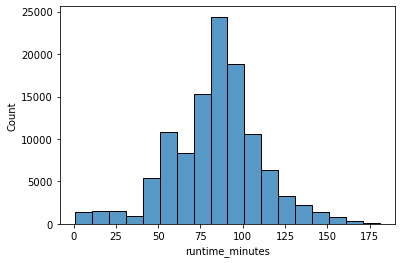

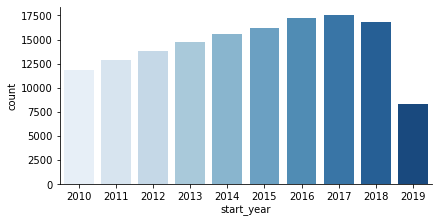

In [4]:
# Review distribution plots
length180 = imdb_basics[imdb_basics['runtime_minutes'] < 180]
sns.histplot(data=length180, x='runtime_minutes', binwidth=10, palette='Blues')

keepyears = imdb_basics[imdb_basics['start_year'].between(2010,2019)]
sns.catplot(data=keepyears, kind='count', x='start_year', palette='Blues', height=3, aspect=2)


#### BOM Movie Gross File

In [ ]:
# BOM Movie Gross File - explore data quality
print(bom.head(2))
print(bom.info()) # Nulls 31K minutes, 5K genre
print(bom.describe())
bom['year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
bom['studio'].value_counts(sort=True) #Majority single genres but 1085 combinations

In [ ]:
print(f"\n**{bom.duplicated(['title'],keep=False).sum()} duplicates found based on title**\n") #No dups
print(f"\n**{bom.duplicated(['title'],keep=False)} duplicates found based on title**\n") #No dups

#### TN Budgets File

In [199]:
# TN Budgets File - explore data quality
display(tn.head(2))
display(tn.info()) # Nulls 31K minutes, 5K genre
print(tn.describe())
tn.groupby(by='year').sum().sort_values(by='year', ascending=False).head(10) #Consistent data through 2016 then drop

tn.duplicated(['movie','year'],keep=False).sum()
tn[tn.duplicated(['movie','year'],keep=False)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00","2,351,345,279.00",553.26
1,2.00,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00","2,011.00","635,063,875.00",154.67


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5781 entries, 0 to 5781
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5781 non-null   float64       
 1   release_date       5781 non-null   datetime64[ns]
 2   movie              5781 non-null   object        
 3   production_budget  5781 non-null   float64       
 4   domestic_gross     5781 non-null   float64       
 5   worldwide_gross    5781 non-null   float64       
 6   year               5781 non-null   float64       
 7   worldwide_profit   5781 non-null   float64       
 8   profit_margin      5781 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 451.6+ KB


None

            id  production_budget  domestic_gross  worldwide_gross     year  \
count 5,781.00           5,781.00        5,781.00         5,781.00 5,781.00   
mean     50.37      31,593,221.16   41,880,570.13    91,503,286.45 2,003.97   
std      28.82      41,813,653.90   68,244,277.37   174,730,937.87    12.73   
min       1.00           1,100.00            0.00             0.00 1,915.00   
25%      25.00       5,000,000.00    1,430,241.00     4,128,828.00 2,000.00   
50%      50.00      17,000,000.00   17,231,291.00    27,989,498.00 2,007.00   
75%      75.00      40,000,000.00   52,353,636.00    97,651,543.00 2,012.00   
max     100.00     425,000,000.00  936,662,225.00 2,776,345,279.00 2,020.00   

       worldwide_profit  profit_margin  
count          5,781.00       5,781.00  
mean      59,910,065.29         378.61  
std      146,098,763.77       2,951.17  
min     -200,237,650.00        -100.00  
25%       -2,178,990.00         -50.71  
50%        8,554,727.00          70.90  
7

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin


In [228]:
print(f'Note: TN file has {tn.movie.size} unique titles. IMDB Basics has {movies.primary_title.size}.')

keep = ['movie','year','production_budget','domestic_gross','worldwide_gross','worldwide_profit','profit_margin']
l_keys = ['start_year', 'primary_title']
r_keys = ['year','movie']
movies = movies.merge(tn[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='tn_ind')
movies.drop(columns=['movie','year'], inplace=True)

Note: TN file has 5781 unique titles. IMDB Basics has 146146.


In [229]:
movies['tn_ind'].value_counts()

#movies = movies.merge(tn[keep], how='left', left_on='primary_title', right_on='movie', indicator='tn_ind')

left_only     144599
both            1547
right_only         0
Name: tn_ind, dtype: int64

## Feature Engineering

### Extend IMDB Basics with Ratings 

In [227]:
# Create Movies DF - basics left join to ratings and bom 
movies = imdb_basics.merge(imdb_ratings, how='left', left_on='tconst', right_on='tconst', indicator='rating_ind')
movies.drop(columns=['original_title'], inplace=True)

movies = movies.merge(bom, how='left', left_on='primary_title', right_on='title', indicator='gross_ind')
movies.drop(columns=['title','year'], inplace=True)

movies['title_cnt'] = 1

movies.head(100)

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,studio,domestic_gross,foreign_gross,gross_ind,title_cnt
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.00,77,both,NaN,<NA>,<NA>,left_only,1
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.20,43,both,NaN,<NA>,<NA>,left_only,1
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.90,4517,both,NaN,<NA>,<NA>,left_only,1
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.10,13,both,NaN,<NA>,<NA>,left_only,1
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.50,119,both,NaN,<NA>,<NA>,left_only,1
5,tt0111414,A Thin Life,2018,75,Comedy,nan,<NA>,left_only,NaN,<NA>,<NA>,left_only,1
6,tt0112502,Bigfoot,2017,<NA>,"Horror,Thriller",4.10,32,both,NaN,<NA>,<NA>,left_only,1
7,tt0137204,Joe Finds Grace,2017,83,"Adventure,Animation,Comedy",8.10,263,both,NaN,<NA>,<NA>,left_only,1
8,tt0139613,O Silêncio,2012,<NA>,"Documentary,History",nan,<NA>,left_only,NaN,<NA>,<NA>,left_only,1
9,tt0144449,Nema aviona za Zagreb,2012,82,Biography,nan,<NA>,left_only,NaN,<NA>,<NA>,left_only,1


In [ ]:
movies.groupby(['rating_ind','gross_ind']).size() # 98% have ratings, less than 5% have gross sales


### IMDB Basics Genre

In [ ]:
# Concatenate non-null genres series strings together in unique list
genres_list = ','.join(str(x) for x in imdb_basics['genres'].dropna().unique())
# Split genres list into unique set of genres
genres_unique = set(x for x in genres_list.split(','))

# Loop unique genres, create new boolean series for each genre; useful for correlations
for genre in sorted(genres_unique):
    imdb_basics['is_'+genre.lower()] = imdb_basics.apply(lambda x: int(genre in str(x.genres)), axis=1)

imdb_basics.head(50)

### IMDB Ratings

In [ ]:

imdb_ratings.head()
imdb_ratings.info()
imdb_ratings.duplicated(['tconst'],keep=False).sum()

## Business Analysis

### Best profit margins by genre

Profits = Worldwide Sales - Production Costs
Profit Margins = Profits / Production Costs
Notes: Sales and costs are adjusted by CPI factor, limited data sets have this data.

#### Group By Genres

                             genres  Movie_Count  Subtotal  Pct_Total
693                     Documentary        32106    145083  22.129402
793                           Drama        21306    145083  14.685387
493                          Comedy         9096    145083   6.269515
991                          Horror         4310    145083   2.970713
526                    Comedy,Drama         3497    145083   2.410344
1077                       Thriller         2985    145083   2.057443
0                            Action         2164    145083   1.491560
432           Biography,Documentary         2115    145083   1.457786
871                   Drama,Romance         2069    145083   1.426080
536            Comedy,Drama,Romance         1554    145083   1.071111
694               Documentary,Drama         1552    145083   1.069732
607                  Comedy,Romance         1502    145083   1.035269
1060                        Romance         1443    145083   0.994603
750               Do

[Text(0.5, 1.0, 'Movies By Genre Type 2010 through 2019')]

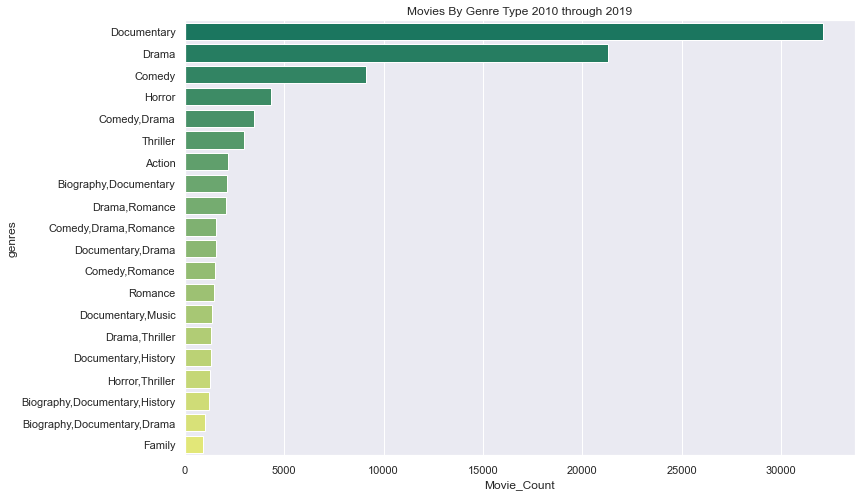

In [16]:
# Top movie genres 2010-2019
year_filter = movies['start_year'].between(2010,2019)
titles = movies[year_filter].groupby('genres', as_index=False).agg(Movie_Count = ('title_cnt', 'sum')).sort_values('Movie_Count', ascending=False)[:20]
titles['Subtotal'] = movies[year_filter].title_cnt.sum()
titles['Pct_Total'] = (titles['Movie_Count']*100 / titles['Subtotal'])
print(titles)

# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles, orient='h', x = 'Movie_Count', y = 'genres', palette='summer')
ax.set(title='Movies By Genre Type 2010 through 2019') # title barplot


#### Group By Unique Genre

In [10]:
# Top dervied movie genres 2010-2019
g_cnt_der = movies[['tconst', 'start_year', 'genres', 'title_cnt', 'runtime_minutes', 'rating_ind', 
                    'avg_rating', 'num_votes']]

g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()
g_cnt_der = g_cnt_der.explode('genres')
g_cnt_der['title_cnt_der'] = g_cnt_der['title_cnt'] / g_cnt_der['num_genres']
genre_list = ['Reality-TV','Talk-Show','Adult','Short','Game-Show']
g_cnt_der = g_cnt_der[(g_cnt_der.start_year.between(2010,2019)) & (~g_cnt_der.genres.isin(genre_list))]

titles_der = g_cnt_der.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])
titles_der

<ipython-input-10-dd8aa0135c2e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
<ipython-input-10-dd8aa0135c2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()


,genres,movie_count,avg_runtime_mins,avg_rating_avg,num_votes_avg,total_movies,pct_total
6,Documentary,40209.166667,72.101788,7.332090,266.960232,139590.833333,28.805019
7,Drama,32887.666667,94.280837,6.401559,3883.574769,139590.833333,23.560048
4,Comedy,15754.666667,93.923819,6.002689,4297.617409,139590.833333,11.286319
11,Horror,6902.166667,87.352216,5.003583,3112.014853,139590.833333,4.944570
19,Thriller,6561.666667,94.353396,5.639207,5859.890728,139590.833333,4.700643
0,Action,5182.500000,100.020867,5.810361,14476.485690,139590.833333,3.712636
16,Romance,4731.000000,100.219722,6.146608,4084.667324,139590.833333,3.389191
3,Biography,3653.500000,74.124302,7.162274,5673.259648,139590.833333,2.617292
8,Family,2987.333333,83.189049,6.394725,2531.274912,139590.833333,2.140064
5,Crime,2966.000000,95.513259,6.115441,8594.959011,139590.833333,2.124781


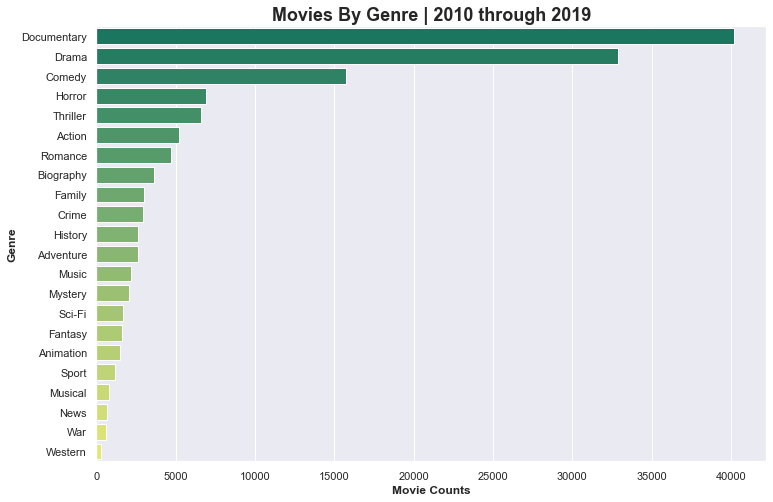

In [11]:
# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_title('Movies By Genre | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
plt.show()
# Possibly add cumulative % 2nd axis

#### Counts By Genre Chart

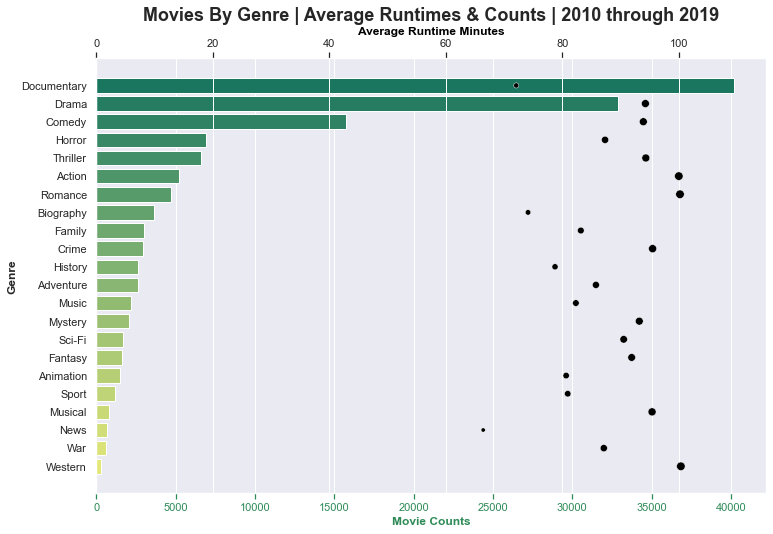

In [26]:
# Plot the top 22 genres by movie count and runtime minutes from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax_color = 'seagreen'
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) 
ax.xaxis.label.set_color(ax_color)
ax.set_xlim(0, None)
ax.tick_params(axis='x', colors=ax_color)
ax.set_title('Movies By Genre | Average Runtimes & Counts | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 

#specify we want to share the same x-axis
ax2 = ax.twiny()
ax2_color = 'black'
ax2 = sns.scatterplot(data = titles_der, x = 'avg_runtime_mins', y = 'genres', color=ax2_color, size='avg_runtime_mins', legend=False)
ax2.set_xlim(0, 115)
ax2.set_xlabel('Average Runtime Minutes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color)
plt.show()

#### Ratings By Genre Chart

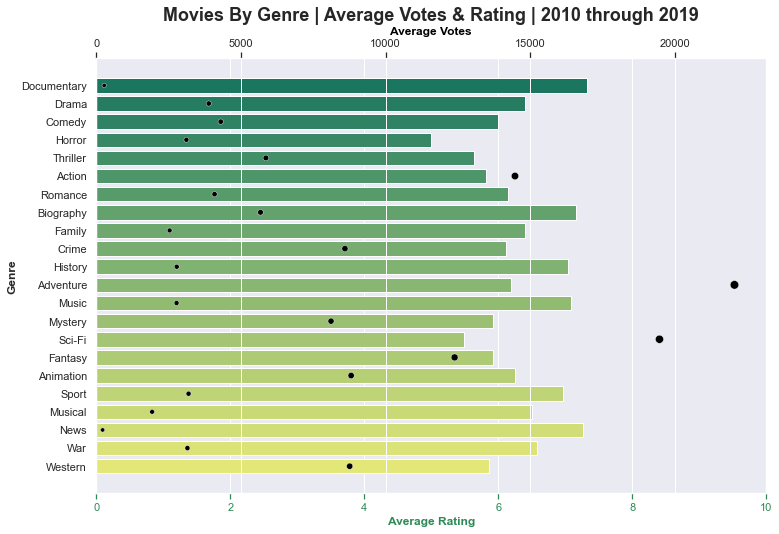

In [24]:
# Plot the top 22 genres by average movie rating and votes from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")

ax_color = 'seagreen'
ax = sns.barplot(data = titles_der, orient='h', x = 'avg_rating_avg', y = 'genres', palette='summer')
ax.set_xlabel('Average Rating', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) 
ax.xaxis.label.set_color(ax_color)
ax.set_xlim(0, 10)
ax.tick_params(axis='x', colors=ax_color)
ax.set_title('Movies By Genre | Average Votes & Rating | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 

#specify we want to share the same x-axis
ax2 = ax.twiny()
ax2_color = 'black'
ax2 = sns.scatterplot(data = titles_der, x = 'num_votes_avg', y = 'genres', color=ax2_color, size='num_votes_avg', legend=False)
ax2.set_xlim(0, None)
ax2.set_xlabel('Average Votes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color)

plt.show()

In [ ]:
#agg_rating = movies[movies['rating_ind']=True].groupby('genres', as_index=False).agg(Avg_Votes=('num_votes','mean'),
#                                                  Avg_Rating=('avg_rating','mean'))

## Deprecated Code

In [ ]:
# IMDB Basics parse and featurize genres
def match_genre(target_genre, title_genres):
    result = 0
    if title_genres: 
        for genre in title_genres:
            if genre == target_genre: 
                result += 1
            else:     
                result += 0
    if result > 0: result = 1
    return result

unique_genres = sorted(imdb_basics['genres'].str.split(pat=",").explode().dropna().unique())
genre_series = imdb_basics['genres'].str.split(pat=",")

for key, genre in genre_series.head(50).items():
    for g in unique_genres:
        match = match_genre(g, genre)
        #print(genre, g, match)
        genre_series[key][g] = match #old method, had error on this line otherwise function working

imdb_basics.head(50)